I have used the following methods.


* I used two image processing methods for images <span style="color:#e74c3c;"> <b>(Green Channel Conversion[2] , Histogram Equalization[3])</b> </span>
* I used a morphological image processing method for masks <span style="color:#e74c3c;"> <b>(Dilation[4])</b> </span>
* <b>Dice coefficient[5]</b> implementation,
* The project took place using <b>Google TPU</b>,
* <b>Custom layers</b> for encoding and decoding,
* <b>Custom callback</b> class  that used predicting a sample from the test dataset during training
* <b>1000 epochs</b> for training (of course, although this number is very high, the metrics(dice, loss) continued improvement during training)


## My Another Project About Eyes

* [Iris Segmentation U-net w/TPU (Dice Coef: 0.94)](https://www.kaggle.com/code/banddaniel/iris-segmentation-u-net-w-tpu-dice-coef-0-94)
* [Eye Conjunctiva Segmentation with U-Net using TPU (Dice : 0.91, Jaccard : 0.82)](https://github.com/john-fante/eye-conjunctiva-segmentation)


## Test Set Prediction During Training

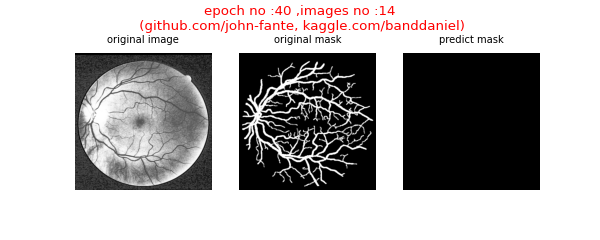
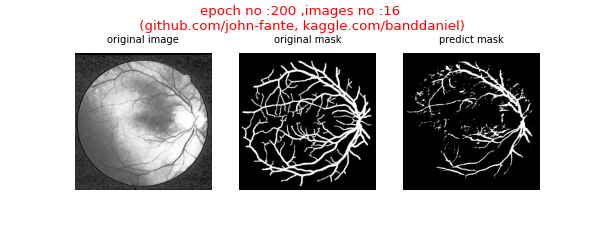
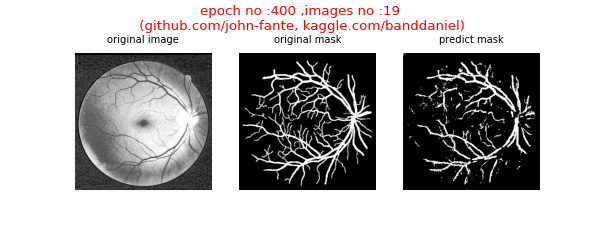
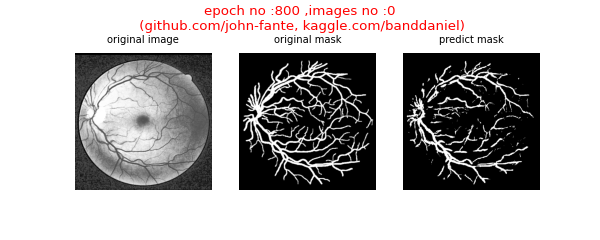
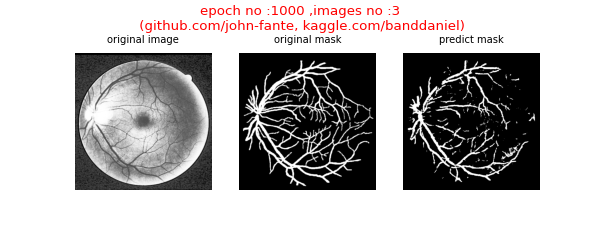

## References
1. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation (Version 1). arXiv. https://doi.org/10.48550/ARXIV.1505.04597
2. Rathod, Deepali & Manza, Ramesh & Rajput, Yogesh & Patwari, Manjiri & Saswade, Manoj & Deshpande, Neha. (2014). Localization of Optic Disc and Macula using Multilevel 2-D Wavelet Decomposition Based on Haar Wavelet Transform. International Journal of Engineering Research & Technology (IJERT)
3. https://en.wikipedia.org/wiki/Histogram_equalization
4. https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm
5. https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient

In [ ]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Layer, concatenate , BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback


BATCH_SIZE = 16

In [ ]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# Creating new folders

os.mkdir(os.path.join('/kaggle/working/', 'train_converted_images'))
os.mkdir(os.path.join('/kaggle/working/', 'train_converted_masks'))

os.mkdir(os.path.join('/kaggle/working/', 'test_converted_images'))
os.mkdir(os.path.join('/kaggle/working/', 'test_converted_masks'))

# <span style="color:#e74c3c;"> Image </span> Processing

* Firstly, I used <b>green channel conversion </b> for RGB (BGR in cv2) retina images. Splitting the green channel, then applied <b>histogram equalization </b>.

* Secondly, I used a morphological technique named <b>dilation</b>, because there are many very tiny vessels in the images. This method has increased model accuracy in respect of dice coefficient.

<span style="color:#16a085;"> <i><b>Green Channel Conversion, Histogram Equalization</b></i>
 </span>


In [ ]:
# An example of image operations

normal_image = cv2.imread('/kaggle/input/retina-blood-vessel/Data/train/image/20.png') #a normal rgb image
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB) #convert to rgb for plotting

green_channnel = normal_image[:,::,1] #splitting Green channel from a RGB image 

hist_eq_image = cv2.equalizeHist(green_channnel) # histogram equalization


fig, axs = plt.subplots(1,3, figsize = (9,5), dpi = 100)

axs[0].imshow(normal_image)
axs[0].set_title('The original image', color = 'red')
axs[0].axis('off')

axs[1].imshow(green_channnel, cmap = 'gray')
axs[1].set_title('The green channel of the image', color ='green')
axs[1].axis('off')

axs[2].imshow(hist_eq_image, cmap = 'gray')
axs[2].set_title('After histogram equalization')
axs[2].axis('off')


In [ ]:
# A normal image > Green channel > Histogram Equalization

def image_cvt_histeq(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        #BGR images, I want to split the green channel
        img = cv2.imread(os.path.join(main_path, i))[:,::,1] 
        img = cv2.equalizeHist(img) # histogram equalization
        cv2.imwrite(os.path.join(target_path, i), img)

<span style="color:#16a085;"> <i><b>Mask Dilation</b></i>
 </span>

In [ ]:
# An example of mask operations

normal_mask = cv2.imread('/kaggle/input/retina-blood-vessel/Data/train/mask/20.png') #a normal mask

kernel = np.ones((2,2))
dilated_mask = cv2.dilate(normal_mask, kernel, iterations = 2)

fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 80)

axs[0].imshow(normal_mask)
axs[0].set_title('The original mask')
axs[0].axis('off')

axs[1].imshow(dilated_mask, cmap = 'gray')
axs[1].set_title('After dilation operation', color ='red')
axs[1].axis('off')



In [ ]:
# Mask dilation operation

def mask_dilation(main_path, target_path, morphological_kernel_size = 2 ):
    main_imgs = sorted(os.listdir(main_path))
    
    for i in main_imgs :
        kernel = np.ones((morphological_kernel_size,morphological_kernel_size))
        
        mask = cv2.imread(os.path.join(main_path, i))
        mask = cv2.dilate(mask, kernel, iterations = 2)
        cv2.imwrite(os.path.join(target_path, i), mask)

In [ ]:
# Applying image processing methods to all images and masks

image_cvt_histeq('/kaggle/input/retina-blood-vessel/Data/train/image', '/kaggle/working/train_converted_images')
mask_dilation('/kaggle/input/retina-blood-vessel/Data/train/mask','/kaggle/working/train_converted_masks' )

image_cvt_histeq('/kaggle/input/retina-blood-vessel/Data/test/image', '/kaggle/working/test_converted_images')
mask_dilation('/kaggle/input/retina-blood-vessel/Data/test/mask', '/kaggle/working/test_converted_masks')

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [ ]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    #for i in tqdm(images, desc = 'images' ):
    for i in images:

        full_path.append(os.path.join(path, i))
        
    return full_path


train_images = create_images_list('/kaggle/working/train_converted_images')
train_masks = create_images_list('/kaggle/working/train_converted_masks')


test_images = create_images_list('/kaggle/working/test_converted_images')
test_masks = create_images_list('/kaggle/working/test_converted_masks')


train_df = pd.DataFrame({'image' : train_images,'mask' : train_masks })
test_df = pd.DataFrame({'image' : test_images,'mask' : test_masks})

In [ ]:
print("train images: ", train_df.shape[0])
print("test images: ", test_df.shape[0])

In [ ]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.resize(img, size = (512, 512))
    img = tf.cast(img, tf.float32)/255.0
    
    mask = tf.io.read_file(label)
    mask = tf.io.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, size = (512, 512))
    mask = tf.cast(mask, tf.float32)/255.0
    
    return img, mask


def img_augmentation(image, label):
    img = tf.image.random_brightness(image, 0.2)
    img = tf.image.random_contrast(img, 0.2, 0.3)
    
    return img, label
    

In [ ]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['mask']))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .map(img_augmentation)
                 .batch(BATCH_SIZE)
                 .shuffle(train_df.shape[0])
                 .prefetch(BATCH_SIZE))


test_loader = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['mask']))
test_dataset = (test_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))

# <span style="color:#e74c3c;"> U-net </span> Model


In [ ]:
# Encoding block for U-net architecture

class EncoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, pooling = True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate
        self.pooling = pooling
        
        self.conv1 = Conv2D(filters, kernel_size, activation = 'relu', strides = 1,  padding = 'same' ,kernel_initializer = 'he_normal')
        self.conv2 = Conv2D(filters, kernel_size, activation= 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal') 
        self.drop = Dropout(rate)
        self.pool = MaxPooling2D()
    
    
    def call(self, inputs):
        X = self.conv1(inputs)
        X = self.drop(X)
        X = self.conv2(X)
        if self.pooling:
            P = self.pool(X)
            return P,X
        else:
            return X
     
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "rate" : self.rate,
            "pooling" : self.pooling }
        

In [ ]:
# Decoding block for U-net architecture

class DecoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate
        
        self.up = UpSampling2D()
        self.nn = EncoderBlock(filters, kernel_size, rate, pooling = False)
    
    
    def call(self, inputs):
        inputs, skip_inputs = inputs
        X = self.up(inputs)
        C = concatenate([X, skip_inputs ])
        X = self.nn(C)
        return X
    
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "rate" : self.rate,
            "pooling" : self.pooling }
        

In [ ]:
# Custom callback for predicting one sample from test dataset during training each 50 epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):
        
        if (epochs + 1) % 50 == 0:
            samples = list(test_dataset.take(-1))
        
            idxs = np.random.permutation(test_df.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs
        
            image = samples[batch_idx][0][image_idx] 
            mask = samples[batch_idx][1][image_idx]
        
            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.75
            bitmap_pred = (pred_ > threshold).astype(np.uint8)
        
            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)
                
            plt.tight_layout()
            plt.show()
        else:
            pass

In [ ]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# <span style="color:#e74c3c;"> Training </span> 


In [ ]:
with strategy.scope():
    inp = Input(shape = (512, 512, 1))

    p1,c1 = EncoderBlock(32, 2, 0.1, name = 'ENCODER_1')(inp)
    p2,c2 = EncoderBlock(64, 2, 0.1, name =  'ENCODER_2')(p1)
    p3,c3 = EncoderBlock(128, 2, 0.2, name =  'ENCODER_3')(p2)
    p4,c4 = EncoderBlock(256, 2, 0.2,  name = 'ENCODER_4')(p3)

    encoding = EncoderBlock(512 , 2, 0.3, pooling = False ,name = 'ENCODING')(p4)
 
    d1 = DecoderBlock(256, 2, 0.2 ,name = 'DECODER_1' )([encoding, c4])
    d2 = DecoderBlock(128 ,2, 0.2 ,name = 'DECODER_2' )([d1, c3])
    d3 = DecoderBlock(64 ,2, 0.1 ,name = 'DECODER_3' )([d2, c2])
    d4 = DecoderBlock(32 ,2, 0.1 ,name = 'DECODER_4' )([d3, c1])

    out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(d4)

    model = Model(inputs = inp, outputs = out)
    #model.summary()

    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef]) 
    my_callbacks = [PredictDuringTraining()]

I used <i>verbose = 0 </i> because there are many lines. But each 50 epochs, the model predicts a sample of the test dataset.

In [ ]:
hist = model.fit(train_dataset, batch_size= BATCH_SIZE,epochs = 1000 , callbacks = my_callbacks, verbose = 0)

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation


In [ ]:
fig, axs = plt.subplots(1,2, figsize = (18,5), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['dice_coef_loss'])
axs[0].legend(["loss", "dice loss"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].legend(["training dice coef"])


In [ ]:
train_eval = model.evaluate(train_dataset)

print('Train Dice Loss : {0:.4f}'.format(train_eval[1]))
print('Train Dice Coefficient : {0:.4f}'.format(train_eval[2]))

# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [ ]:
test_eval = model.evaluate(test_dataset)

print('Test Dice Loss : {0:.4f}'.format(test_eval[1]))
print('Test Dice Coefficient : {0:.4f}'.format(test_eval[2]))

In [ ]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.75 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.95 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)


In [ ]:
# A function that creating one random image in the test set and prediction it

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   

    fig, axs = plt.subplots(3,5, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        segmented = np.squeeze(test_take1_[batch_idx[i]][0][image_idx[i]] ) * pred_mask_1
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 5)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 5)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.75 threshold)', fontsize = 5)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.95 threshold)', fontsize = 5)
        
        axs[i][4].imshow(image , cmap ='gray')
        axs[i][4].imshow(segmented , alpha=0.5,  cmap = 'autumn')
        axs[i][4].axis('off')
        axs[i][4].set_title('segmentated vessel', fontsize = 5)

In [ ]:
random_test_sample_with_prediction()